In [82]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
url = 'https://raw.githubusercontent.com/AmbujaBudakoti27/Sarcasm-Detection/main/sarcasm_detection_shared_task_twitter_training.jsonl'
df=pd.read_json(url,lines=True)

In [ ]:
df.head()

,label,response,context
0,SARCASM,@USER @USER @USER I don't get this .. obviousl...,[A minor child deserves privacy and should be ...
1,SARCASM,@USER @USER trying to protest about . Talking ...,[@USER @USER Why is he a loser ? He's just a P...
2,SARCASM,@USER @USER @USER He makes an insane about of ...,[Donald J . Trump is guilty as charged . The e...
3,SARCASM,@USER @USER Meanwhile Trump won't even release...,[Jamie Raskin tanked Doug Collins . Collins lo...
4,SARCASM,@USER @USER Pretty Sure the Anti-Lincoln Crowd...,[Man ... y ’ all gone “ both sides ” the apoca...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   label     5000 non-null   object
 1   response  5000 non-null   object
 2   context   5000 non-null   object
dtypes: object(3)
memory usage: 117.3+ KB


In [ ]:
df['label'].value_counts()

NOT_SARCASM    2500
SARCASM        2500
Name: label, dtype: int64

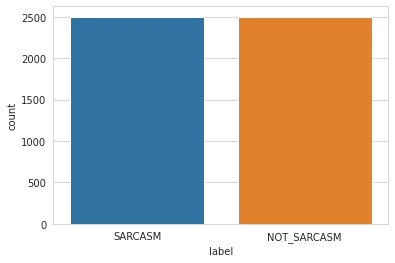

In [ ]:
sns.set_style('whitegrid')
sns.countplot(x='label',data=df)

In [ ]:
def clean_text(text):
    text = text.lower()
    
    pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    text = pattern.sub('', text)
    text = " ".join(filter(lambda x:x[0]!='@', text.split()))
    emoji = re.compile("["
                           u"\U0001F600-\U0001FFFF"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    
    text = text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"that's", "that is", text)        
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text) 
    text = re.sub(r"\'ll", " will", text)  
    text = re.sub(r"\'ve", " have", text)  
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"did't", "did not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"have't", "have not", text)
    text = re.sub(r"[,.\"\'!@#$%^&*(){}?/;`~:<>+=-]", "", text)
    return text


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

def CleanTokenize(df):
    stop_words = set(stopwords.words("english"))
    responses = list()
    lines = df["response"].values.tolist()

    for line in lines:
        line = clean_text(line)
        # tokenize the text
        tokens = word_tokenize(line)
        # remove puntuations
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        # remove non alphabetic characters
        words = [word for word in stripped if word.isalpha()]
        # remove stop words
        words = [w for w in words if not w in stop_words]
        responses.append(words)
    return responses


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
responses = CleanTokenize(df)
responses[0:2]

[['get',
  'obviously',
  'care',
  'would',
  'moved',
  'right',
  'along',
  'instead',
  'decided',
  'care',
  'troll'],
 ['trying', 'protest', 'talking', 'labels', 'label', 'wtf', 'make', 'em']]

In [ ]:
vocab_size=10000
embedding_dim=16
max_length=32
trunc_type='post'
padding_type='post'
oov_tok='<oov>'
validation_split = 0.2

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, GRU, LSTM, Bidirectional
from keras.layers.embeddings import Embedding
from keras.initializers import Constant
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

In [ ]:
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(responses)
sequences = tokenizer_obj.texts_to_sequences(responses)

word_index = tokenizer_obj.word_index
print("unique tokens - ",len(word_index))
vocab_size = len(tokenizer_obj.word_index) + 1
print('vocab size -', vocab_size)

lines_padded = pad_sequences(sequences, maxlen=max_length, padding='post')


unique tokens -  12451
vocab size - 12452


In [ ]:
indices = np.arange(lines_padded.shape[0])
np.random.shuffle(indices)
lines_padded = lines_padded[indices]

In [ ]:
y = pd.get_dummies(df['label'])
y = y.iloc[:,1].values
y

array([1, 1, 1, ..., 0, 0, 0], dtype=uint8)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(lines_padded, y, test_size=validation_split, random_state=0)

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2021-07-07 09:06:26--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-07-07 09:06:26--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-07-07 09:06:26--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
path_to_glove_file = os.path.join("/content/glove.6B.100d.txt")

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
embeddings_index['ice']

array([-0.36987 ,  0.22726 ,  0.19694 ,  0.31698 , -0.27173 , -0.55686 ,
        0.77389 ,  0.027718, -0.69677 , -0.45731 ,  0.15141 , -0.43869 ,
        0.12488 ,  0.29045 , -0.067116,  0.23533 ,  0.66437 , -0.2439  ,
       -0.35008 , -0.56176 , -0.54178 ,  1.3804  , -0.00226 ,  0.14159 ,
        0.22049 ,  0.76038 , -0.65328 , -0.92936 ,  0.44192 , -0.22163 ,
       -0.038148,  0.34207 , -0.31907 , -0.40438 ,  0.32958 , -0.51679 ,
        0.3803  ,  0.6268  , -0.21689 , -1.1499  ,  0.17408 , -0.7247  ,
       -0.60663 , -0.43917 ,  0.51346 ,  0.97305 , -0.44658 , -0.34701 ,
        0.6762  , -0.1245  ,  0.37643 , -0.51666 , -0.01559 ,  0.95627 ,
       -0.21546 , -2.1626  , -0.14155 ,  0.4946  ,  1.3148  ,  1.4727  ,
        0.072711,  1.1756  , -0.29757 ,  0.70818 ,  0.57854 ,  0.21456 ,
        0.545   , -0.33628 ,  0.24096 , -0.69244 , -0.44921 , -0.77919 ,
        0.66128 ,  1.1407  ,  0.25976 , -0.11607 ,  0.77184 , -0.30579 ,
        0.30462 ,  0.45228 ,  0.45382 ,  0.2194  , 

In [ ]:
num_tokens = vocab_size
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 10551 words (1900 misses)


In [ ]:
embedding_matrix[2]

array([-0.2687    ,  0.81708002,  0.69896001, -0.72341001,  0.091566  ,
        0.19557001, -0.52112001, -0.24313   , -0.44701001, -0.27039   ,
       -0.34125999, -0.46898001,  0.42583001,  0.46289   ,  0.17106   ,
       -0.26795   ,  0.23162   ,  0.46568   , -0.31808001,  0.75875002,
        0.31856999,  0.64124   ,  0.067042  , -0.18516999,  0.49996001,
        0.36963999, -0.31172001, -0.73097998, -0.26901999, -0.32058001,
        0.23394001,  0.24276   ,  0.1426    , -0.2793    ,  0.38823   ,
        0.42398   ,  0.1021    ,  0.33316001,  0.30149999, -0.52710998,
       -0.024475  , -0.15301   , -0.3224    , -0.51231003, -0.55250001,
        0.29819   ,  0.10847   ,  0.052334  , -0.2298    , -0.77889001,
       -0.08928   ,  0.48109001,  0.015368  ,  0.92544001, -0.26122001,
       -2.47589993, -0.019825  ,  0.58280998,  1.30599999,  0.73512   ,
       -0.34371999,  1.58290005, -0.10814   ,  0.11388   ,  0.79220003,
        0.18347   ,  1.22319996,  0.35697001,  0.17504001, -0.16

In [ ]:
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

In [ ]:
embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)

In [ ]:
from tensorflow.keras import layers

input = keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(input)
x = layers.LSTM(64, dropout=0.2, recurrent_dropout=0.25)(embedded_sequences)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
preds = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(input, preds)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_5 (Embedding)      (None, None, 100)         1245200   
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 1,295,889
Trainable params: 50,689
Non-trainable params: 1,245,200
____________________________________________

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=32, epochs=25, validation_data=(X_test, y_test), verbose=1)

Epoch 1/25
125/125 [==============================] - 7s 40ms/step - loss: 0.6932 - accuracy: 0.5132 - val_loss: 0.6931 - val_accuracy: 0.4930
Epoch 2/25
125/125 [==============================] - 5s 37ms/step - loss: 0.6932 - accuracy: 0.5038 - val_loss: 0.6930 - val_accuracy: 0.4990
Epoch 3/25
125/125 [==============================] - 5s 38ms/step - loss: 0.6930 - accuracy: 0.5010 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 4/25
125/125 [==============================] - 5s 38ms/step - loss: 0.6929 - accuracy: 0.5203 - val_loss: 0.6933 - val_accuracy: 0.4910
Epoch 5/25
125/125 [==============================] - 5s 37ms/step - loss: 0.6926 - accuracy: 0.5160 - val_loss: 0.6933 - val_accuracy: 0.4950
Epoch 6/25
125/125 [==============================] - 5s 39ms/step - loss: 0.6924 - accuracy: 0.5182 - val_loss: 0.6935 - val_accuracy: 0.4980
Epoch 7/25
125/125 [==============================] - 5s 37ms/step - loss: 0.6922 - accuracy: 0.5235 - val_loss: 0.6932 - val_accuracy: 0.4970

In [ ]:
df_m=pd.DataFrame(model.history.history)
df_m['Epoch']=range(1,26)
df_m.index=df_m['Epoch']
df_m

,loss,accuracy,val_loss,val_accuracy,Epoch
Epoch,,,,,
1,0.693188,0.51325,0.693092,0.493,1
2,0.693193,0.50375,0.693022,0.499,2
3,0.692978,0.50100,0.693021,0.500,3
4,0.692855,0.52025,0.693261,0.491,4
5,0.692623,0.51600,0.693315,0.495,5
6,0.692395,0.51825,0.693488,0.498,6
7,0.692230,0.52350,0.693248,0.497,7
8,0.691730,0.52500,0.693347,0.492,8
9,0.691600,0.51925,0.693651,0.488,9


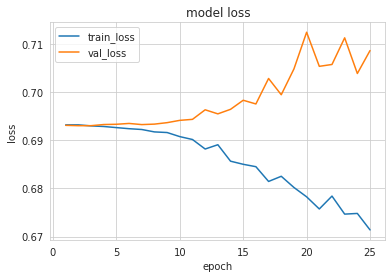

In [ ]:
#Loss Graph(Training and Validation)
plt.plot(df_m['loss'])
plt.plot(df_m['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

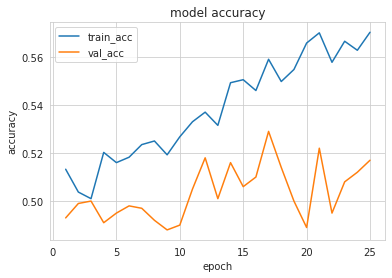

In [ ]:
#fig= plt.figure(figsize=(15,10))
plt.plot(df_m['accuracy'])
plt.plot(df_m['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'])
plt.show()